# Commandes d'import

In [1]:
# Numerical analysis module
import numpy as np
# Plot module
import matplotlib.pyplot as plt
import pandas as pd
# read netCDF files
import xarray as xr
import datetime
import openpyxl

In [2]:
infoBat = pd.DataFrame({'nEtages' : np.array([1,1,4,7,3]), \
                        'nSalles' : np.array([4,2,16,35,10]), \
                        'ville' : ["Paris","Paris","Montreuil","Paris","Paris"], \
                        'cafet' : [False, False, True, True, False], \
                        'tempMoy' : np.array([18.4, 19.0, 21.1, 19.5, 20.0])}, \
                        index = ["BatA", "PC Secu", "BatB", "BatC", "BatD"],
                        columns = ["nEtages","nSalles","ville","cafet","tempMoy"])
infoBat

,nEtages,nSalles,ville,cafet,tempMoy
BatA,1,4,Paris,False,18.4
PC Secu,1,2,Paris,False,19.0
BatB,4,16,Montreuil,True,21.1
BatC,7,35,Paris,True,19.5
BatD,3,10,Paris,False,20.0


In [6]:
date_time = pd.to_datetime(data['Time (UTC)'][1])
date_time

Timestamp('2000-06-30 22:00:00+0000', tz='UTC')

In [29]:
catExcel = pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='E:P')
climate_data = pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='T:U')
data = catExcel[1:-1]
climate = climate_data[1:-1]
#    data.iloc[:,1:-1]
climate
#data

,SOLAR_FC,WIND_FC
1,0.00,0.23
2,0.00,0.23
3,0.00,0.19
4,0.00,0.12
5,0.00,0.10
...,...,...
8731,0.38,0.35
8732,0.26,0.31
8733,0.17,0.33
8734,0.07,0.26


In [6]:
data['diesel ']

1       1.4
2       0.4
3       6.2
4       6.6
5       7.0
       ... 
8731    0.0
8732    0.0
8733    0.0
8734    0.0
8735    6.0
Name: diesel , Length: 8735, dtype: float64

# Traitement de données

In [7]:
#Generator 
solar_gen = 20  #MW
wind_gen = 20  #Mw
diesel_gen = 20 #Mw

#Storage 
charging_power = 5  #MW
Energy = 10 ##MWh

In [8]:
wind_fc= xr.DataArray(
data=climate['WIND_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Wind context data', units ='t')  
    )
solar_fc= xr.DataArray(
data=climate['SOLAR_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Radiation context data', units ='t')  
    )

load= xr.DataArray(
data=data['Load'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Demande en MWH')  
    )
context = xr.merge([load,wind_fc,solar_fc])

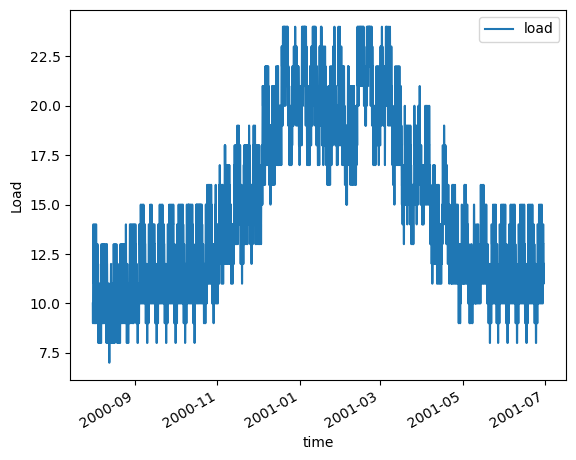

In [37]:
context.Load.sel(time=slice('2000-08-01','2001-08-01')).plot(label='load')
plt.legend()

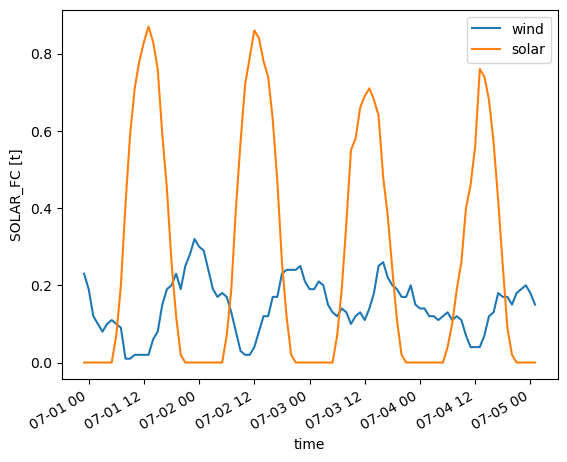

In [39]:
i=0
wind_fc.isel(time=slice(i+1,i+100)).plot(label='wind')
solar_fc.isel(time=slice(i+1,i+100)).plot(label='solar')
plt.legend()

In [11]:
solar_prod = context.Load.copy()
solar_prod = context.SOLAR_FC*solar_gen

wind_prod = context.Load.copy()
wind_prod = context.WIND_FC*wind_gen

net_load=context.Load.copy()
net_load = context.Load -solar_prod - wind_prod

missing_capacity = net_load.copy() - diesel_gen
missing_capacity.values = (abs(missing_capacity.values)+missing_capacity.values)/2



### Computing the Charging / Releasing and Stocks Data

In [12]:
missing_capacity.isel(time=slice(5,50))

<xarray.DataArray (time: 45)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 2000-07-01T03:00:00 ... 2000-07-02T23:00:00

In [60]:
load

<xarray.DataArray 'Load' (time: 8735)>
array([11., 10., 10., ..., 12., 11., 12.])
Coordinates:
  * time     (time) datetime64[ns] 2000-06-30T22:00:00 ... 2001-06-29T20:00:00
Attributes:
    description:  Demande en MWH

In [40]:
#Computing the charging Data
#Copy the structure 
# It works nead to 
charging = context.Load.copy()
stock = context.Load.copy()
releasing = context.Load.copy()
stock.values[0]=5
charging.values[0]=0
releasing.values[0]=5
#reseasing = context.Load.copy()
#for i in range(1,len(charging.values)):
for i in range(1,len(charging.values)):
    remain_energy = net_load.values[i]<0 #BOOL 
    five_day_missing_cap =np.sum(missing_capacity.isel(time=slice(i+1,i+119)))
    missing_storage = five_day_missing_cap>stock.values[i-1] #BOOL
    five_day_missing_capacity = five_day_missing_cap>0
    one_hour_missing_capacity = missing_capacity.values[i]>0
    diesel_charging = np.min([five_day_missing_cap , diesel_gen-net_load.values[i] ,Energy-stock.values[i-1]])
    charging.values[i]=np.min([charging_power,remain_energy*(np.min([-net_load.values[i],Energy-stock.values[i-1]]))+
                            (1-remain_energy)*(missing_storage*0.5*(np.abs(diesel_charging)+diesel_charging))])
    releasing.values[i]= np.min([charging_power,one_hour_missing_capacity*np.min([missing_capacity.values[i],stock.values[i-1]]) 
                            +(1-one_hour_missing_capacity)*(1-five_day_missing_capacity)*
                            np.min([0.5*(np.abs(net_load.values[i])+net_load.values[i]),stock.values[i-1]])])
    stock.values[i]= stock.values[i-1] + charging.values[i]-releasing.values[i]

### Last values to compute


In [15]:
diesel = context.Load.copy()
unserved_energy = context.Load.copy()
unused_energy = context.Load.copy()

### Checks 

In [41]:

charging_check= xr.DataArray(
data=data['charging'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
missing_capacity_check= xr.DataArray(
data=data['Missing capacity'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
releasing_check= xr.DataArray(
data=data['releasing'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
diesel_check= xr.DataArray(
data=data['diesel '],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
unserved_energy_check= xr.DataArray(
data=data['Unserved energy'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )

unused_energy_check= xr.DataArray(
data=data['unused energy'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
#t = xr.merge([load,solar,wind,net_load,charging,missing_capacity,releasing,diesel,unserved_energy,unused_energy])

In [56]:
#np.sum(charging_check-charging)
(releasing_check-releasing).sum()
#(charging_check-charging).sum()

<xarray.DataArray ()>
array(-4.2)

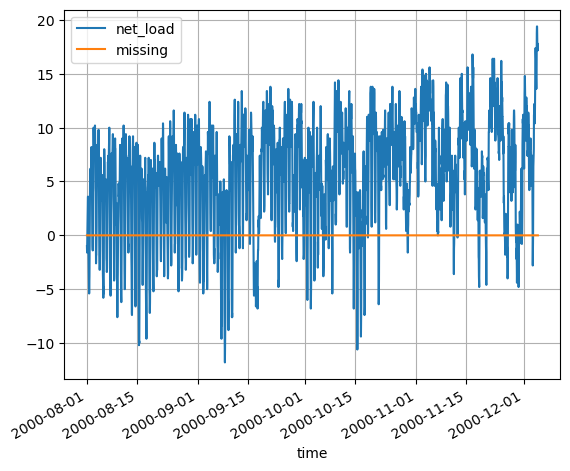

In [28]:
#load.sel(time=slice('2000-08-01','2000-08-04')).plot(label='load')
#solar_prod.sel(time=slice('2000-08-01','2000-08-04')).plot(label='solar')
#wind_prod.sel(time=slice('2000-08-01','2000-08-04')).plot(label='wind')
net_load.sel(time=slice('2000-08-01','2000-12-04')).plot(label='net_load')
missing_capacity.sel(time=slice('2000-08-01','2000-12-04')).plot(label='missing')
plt.legend()
plt.axis()
plt.grid()